In [1]:
import tensorflow

In [2]:
import pandas

In [4]:
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt                   
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer 

In [10]:
# Define IAM role
role = get_execution_role()
prefix = 'sagemaker/DEMO-xgboost-dm'
containers = {'ap-southeast-1': '324986816169.dkr.ecr.ap-southeast-1.amazonaws.com/xgboost-neo:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'} # each region has its XGBoost container
my_region = boto3.session.Session().region_name # set the region of the instance
print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + containers[my_region] + " container for your SageMaker endpoint.")

Success - the MySageMakerInstance is in the ap-southeast-1 region. You will use the 324986816169.dkr.ecr.ap-southeast-1.amazonaws.com/xgboost-neo:latest container for your SageMaker endpoint.


In [18]:
bucket_name = 'sagemaker-s3-cement-91816067' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
s3 = boto3.resource('s3')
try:
    if  my_region == 'ap-southeast-1':
        print("this")
        s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': 'ap-southeast-1' })
    else: 
        s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': 'ap-southeast-1' })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

this
S3 bucket created successfully


In [19]:
bucket='sagemaker-s3-cement-91816067'
data_key = 'cement.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

df = pd.read_csv(data_location)

In [21]:
concrete_data = df

In [25]:
import time
from sklearn.model_selection import train_test_split


In [26]:
t = time.time()
min_d = concrete_data.min()
max_d = concrete_data.max()
normalized_df=(concrete_data - min_d)/(max_d - min_d)

normal_train = normalized_df.iloc[:,:8]
normal_label = normalized_df.iloc[:,-1:]


xtrain, xtest, ytrain, ytest = train_test_split(normal_train, normal_label, test_size = 0.15, random_state = 1)

In [27]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(875, 8)
(875, 1)
(155, 8)
(155, 1)


In [28]:
from tensorflow import keras
from tensorflow.keras import layers

In [32]:
import tensorflow as tf
def build_model():
    model = keras.Sequential([
      layers.Dense(30, activation=tf.nn.relu, input_shape=[len(xtrain.keys())]),
      layers.Dense(25, activation=tf.nn.relu),
      layers.Dense(15, activation=tf.nn.relu),
      layers.Dense(1, activation=tf.nn.sigmoid)
    ])
    
    optimizer = tf.keras.optimizers.SGD(lr=0.01)
    
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model


In [33]:
model = build_model()

model.summary()

example_batch = xtrain[:10]
example_result = model.predict(example_batch)
example_result

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 25)                775       
_________________________________________________________________
dense_2 (Dense)              (None, 15)                390       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 16        
Total params: 1,451
Trainable params: 1,451
Non-trainable params: 0
_________________________________________________________________


array([[0.4904159 ],
       [0.47799286],
       [0.5281465 ],
       [0.47689748],
       [0.48683068],
       [0.4745824 ],
       [0.50711143],
       [0.4505971 ],
       [0.49322692],
       [0.52174467]], dtype=float32)

In [34]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 1000 == 0:
          print('epoch: ', epoch,' loss: ', logs["loss"], "val_loss", logs["val_loss"])

In [36]:
EPOCHS = 14000
history = model.fit(xtrain, ytrain,epochs=EPOCHS, verbose=0,validation_split = 0.2,callbacks=[PrintDot()])
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist.head())
print(hist.tail())

epoch:  0  loss:  0.047721451222896574 val_loss 0.050047326577561245
epoch:  1000  loss:  0.011551719467554773 val_loss 0.013741299754806927
epoch:  2000  loss:  0.0062856162791805606 val_loss 0.008319399833147015
epoch:  3000  loss:  0.004533304918025221 val_loss 0.006718805634549686
epoch:  4000  loss:  0.003904052307563169 val_loss 0.006342801371855395
epoch:  5000  loss:  0.0035802536444472415 val_loss 0.006292576600930521
epoch:  6000  loss:  0.003350979672478778 val_loss 0.006210057948316847
epoch:  7000  loss:  0.0031716978709612573 val_loss 0.00615568893296378
epoch:  8000  loss:  0.0030323879394148078 val_loss 0.0060656797353710445
epoch:  9000  loss:  0.0029009127044784173 val_loss 0.006062894971775157
epoch:  10000  loss:  0.0027647851487355574 val_loss 0.006079334584730012
epoch:  11000  loss:  0.002611796089581081 val_loss 0.006077150721102953
epoch:  12000  loss:  0.002500274475397808 val_loss 0.0061750278701739655
epoch:  13000  loss:  0.0023870539918009726 val_loss 0.00

In [37]:
model.save("my_model_9")

In [38]:
model2 = keras.models.load_model('my_model_9')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


generation: 0
generation: 1
generation: 2
generation: 3
generation: 4
generation: 5
generation: 6
generation: 7
generation: 8
generation: 9
generation: 10
generation: 11
generation: 12
generation: 13
generation: 14
generation: 15
generation: 16
generation: 17
generation: 18
generation: 19
generation: 20
generation: 21
generation: 22
generation: 23
generation: 24
generation: 25
generation: 26
generation: 27
generation: 28
generation: 29
generation: 30
generation: 31
generation: 32
generation: 33
generation: 34
generation: 35
generation: 36
generation: 37
generation: 38
generation: 39
generation: 40
generation: 41
generation: 42
generation: 43
generation: 44
generation: 45
generation: 46
generation: 47
generation: 48
generation: 49
generation: 50
generation: 51
generation: 52
generation: 53
generation: 54
generation: 55
generation: 56
generation: 57
generation: 58
generation: 59
generation: 60
generation: 61
generation: 62
generation: 63
generation: 64
generation: 65
generation: 66
gener

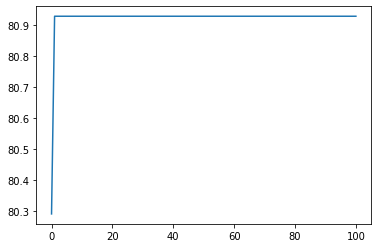

In [41]:
import random
from random import uniform

bounds = np.array([[102,540],[0,359],[0,200],[121,247],[0,32],[801,1145],[594,992],[1,365]])

def evaluate_position(temp):
    temp = np.asarray(temp)
    CNNout=model2.predict(temp)
    CNNout = (CNNout*(82.599225-2.331808))+2.331808
    return CNNout

def fitness(arr):
    ideal = 100
    temp = np.asarray(arr)
    temp = np.absolute(arr-ideal)
    return temp    

       
class Population:
    def __init__(self,n,dim):
        self.pop=np.zeros((n,dim+2))
        self.bestpop = np.zeros((4,dim+1))
        self.dimension = dim
        self.pop_size = n
        for i in range(0,n):
            for j in range(0,self.dimension):
                self.pop[i,j] = random.randint(bounds[j,0], bounds[j,1])
    
    def evaluate_gene(self):
        temp=np.divide(np.subtract(self.pop[:,0:self.dimension],bounds[:,0]),np.subtract(bounds[:,1],bounds[:,0]))
        self.pop[:,self.dimension]=evaluate_position(temp).transpose()
        
    def evaluate_fitness(self):
        self.pop[:,self.dimension+1]=fitness(self.pop[:,self.dimension])
        
    def selection(self):
        arg = self.pop[:,self.dimension+1].argsort()[0:4]
        self.bestpop = self.pop[arg,:]
    
    def crossover(self):
        self.pop[0:4,:]=self.bestpop
        for i in range(4,int(4+(self.pop_size-4)*0.5)):
            sel = [0,1,2,3]
            a = sel.pop(random.randint(0,len(sel)-1))
            b = sel.pop(random.randint(0,len(sel)-1))
            self.pop[i,0:self.dimension//2] = self.bestpop[a,0:self.dimension//2]
            self.pop[i,self.dimension//2:self.dimension] = self.bestpop[b,self.dimension//2:self.dimension]
               
    def mutate(self):
        for i in range(int(4+(self.pop_size-4)*0.5),self.dimension):
            sampl = np.random.uniform(low=0, high=1, size=(1,self.dimension))
            a = random.randint(0,3)
            self.pop[i,0:self.dimension]=np.add(self.bestpop[a,0:self.dimension],np.multiply(self.bestpop[a,0:self.dimension],sampl))
            for j in range(0,self.dimension):
                if self.pop[i,j]>=bounds[j,1]: #prevents search space from exceeding the bound (upper limit)
                    self.pop[i,j]=bounds[j,1] 
                if self.pop[i,j]<=bounds[j,0]: #prevents search space from exeeding the bound (lower limit)
                    self.pop[i,j]=bounds[j,0]
    def print_generation(self):
        print(self.pop)
            
        
np.set_printoptions(suppress=True)
        
def GA(bounds,n_particles,max_gen,dimension):
    t=time.time()
    pop = Population(n_particles,dimension)
    generation = 0
    hist=[]
    while(generation <= max_gen):
        print("generation: "+str(generation))
        pop.evaluate_gene()
        pop.evaluate_fitness()
        pop.selection()
        pop.crossover()
        pop.mutate()
        hist.append(pop.pop[0,dimension])
        generation +=1
    print(time.time()-t)    
    print("optimisation done")
    plt.plot(hist)
    input1 = ['cement','Blast Furnace Slag','Fly Ash','Water','Superplasticizer','Coarse Aggregate','Fine Aggregate','Age','compressive strength']
    for i in range(len(input1)):
        print(input1[i]+": "+str(pop.pop[0,i]))
    
#perform GA wirh model,bounds, 13 paricles, 100 iteration and 8 dimensions
GA(bounds,20,100,8)

In [42]:
model.save('my_model_10')  # creates a HDF5 file 'my_model.h5'
client = boto3.client('s3')
client.upload_file(Filename='my_model_10',
                  Bucket='sagemaker-s3-cement-91816067' ,
                  Key='my_model_10')

In [45]:
from keras.models import load_model
client.download_file('sagemaker-s3-cement-91816067',
                     'my_model.h5',
                     'my_model.h5')
# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')

Using TensorFlow backend.


ValueError: Unknown initializer: GlorotUniform